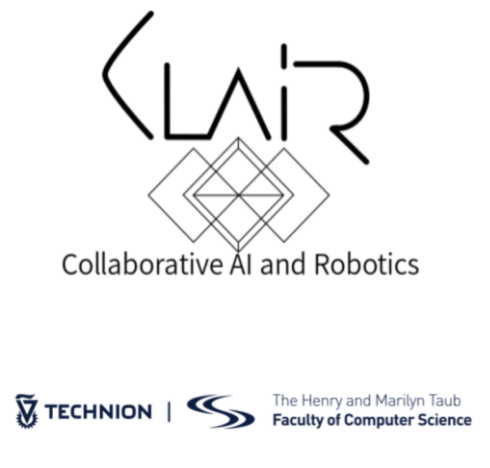

**Originally created by Shiran Dapht, Ido Jacobi, Sarah Keren**

## Running Online On Google Colab

Running the notebook using GPU is limited per day.

#### ⚡**Runtime Type**:  
Ensure that your Colab runtime
is set to GPU by going to Runtime > Change runtime type.

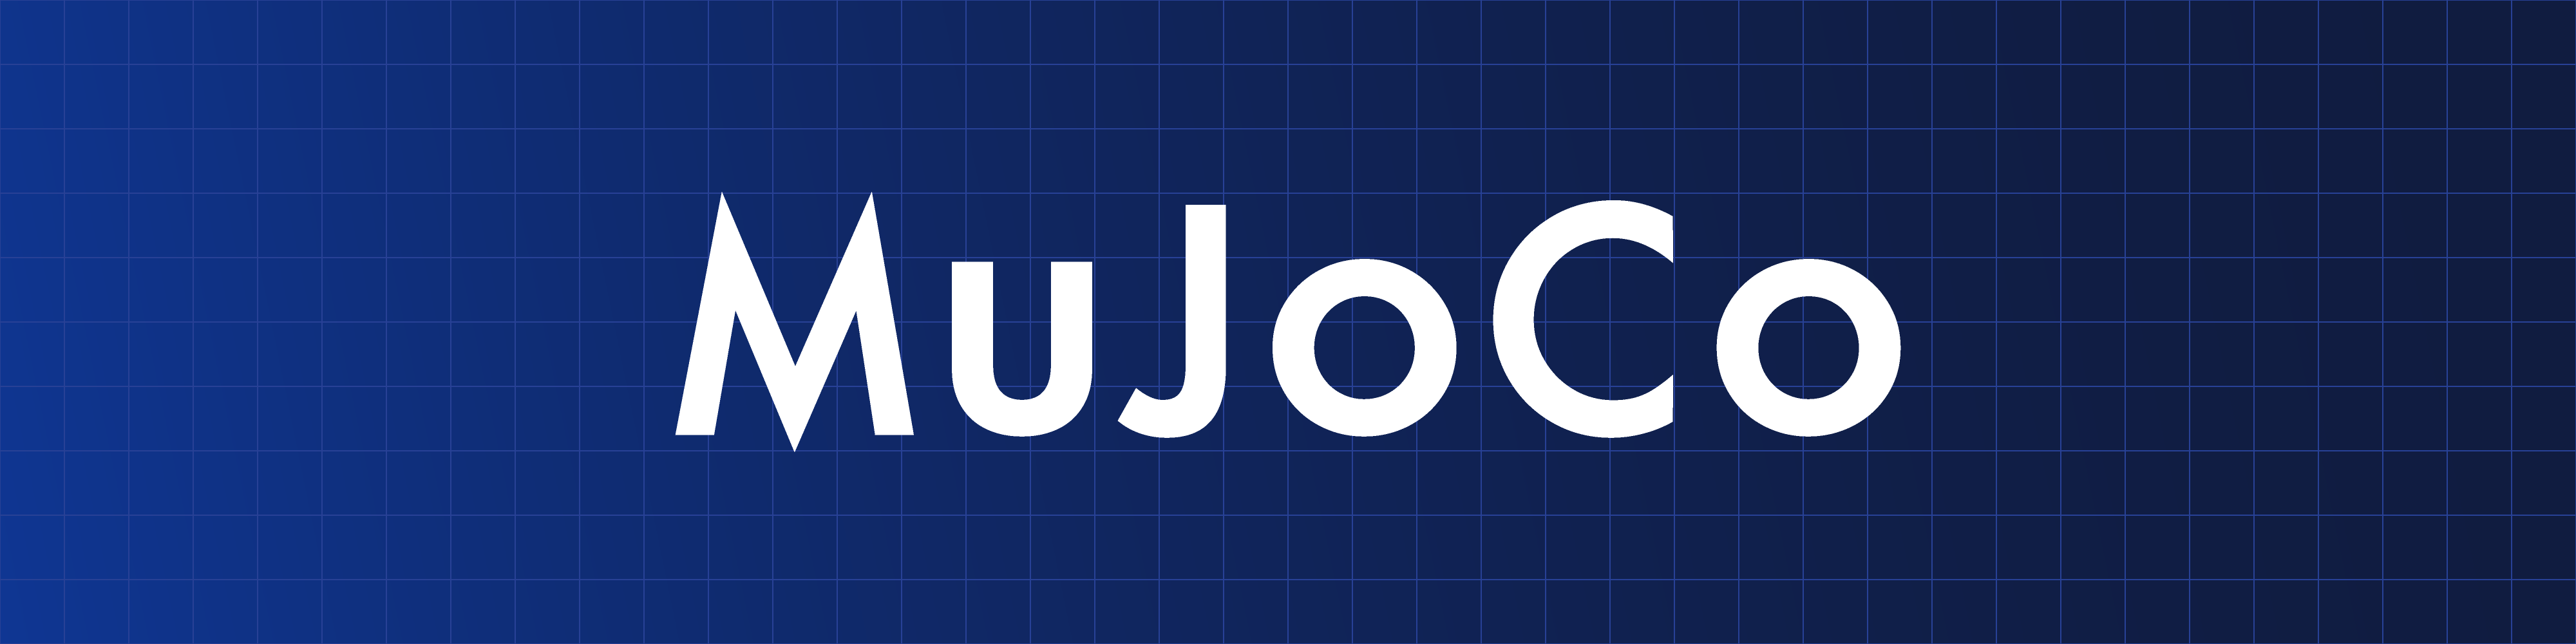

#Introduction to MuJoCo

MuJoCo (Multi-Joint Dynamics with Contact) is a physics engine designed for fast and accurate simulation of complex articulated mechanisms. Originally developed for robotics research, MuJoCo has become widely popular in fields such as biomechanics, machine learning, and reinforcement learning.


👾
This exercise demonstrates only the basics of using MuJoCo. To develop more complex projects with MuJoCo, it is recommended to deepen your knowledge by looking at the MuJoCo documentation. You can find comprehensive information and resources in the MuJoCo documentation at [MuJoCo Documentation](https://mujoco.readthedocs.io/en/stable/overview.html).

In [ ]:
#@title Run to install MuJoCo
import os
import subprocess

# Check for GPU availability
gpu_available = False
try:
    result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
    if result.returncode == 0:
        gpu_available = True
        print("GPU detected and available for use.")
    else:
        print("GPU not detected. Proceeding without GPU support.")
except FileNotFoundError:
    print("nvidia-smi command not found. Proceeding without GPU support.")

NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if gpu_available and not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    os.makedirs('/usr/share/glvnd/egl_vendor.d', exist_ok=True)
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)
    print("NVIDIA ICD configuration added for GPU rendering.")

# Install dm_control
print('Installing dm_control...')
!pip install -q "dm_control>=1.0.25"

# Set the MUJOCO_GL environment variable for GPU rendering if GPU is available
if gpu_available:
    os.environ['MUJOCO_GL'] = 'egl'
    print("Environment variable MUJOCO_GL set to 'egl' for GPU rendering.")
else:
    print("Running without GPU rendering support.")

# Installation of dm_control
print('Verifying dm_control installation...')
try:
    from dm_control import suite
    env = suite.load('cartpole', 'swingup')
    pixels = env.physics.render()
    print('dm_control installation succeeded.')
except Exception as e:
    raise RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".'
    ) from e

# Installation mediapy
!pip install -q mediapy

def display_video(frames: list, framerate: int, filepath:str='simple_simulation.mp4') -> None:
  video_path = filepath
  with imageio.get_writer(video_path, fps=framerate) as video:
    for frame in frames:
        video.append_data(frame)

  from IPython.display import Video, display

  display(Video(filepath, embed=True))


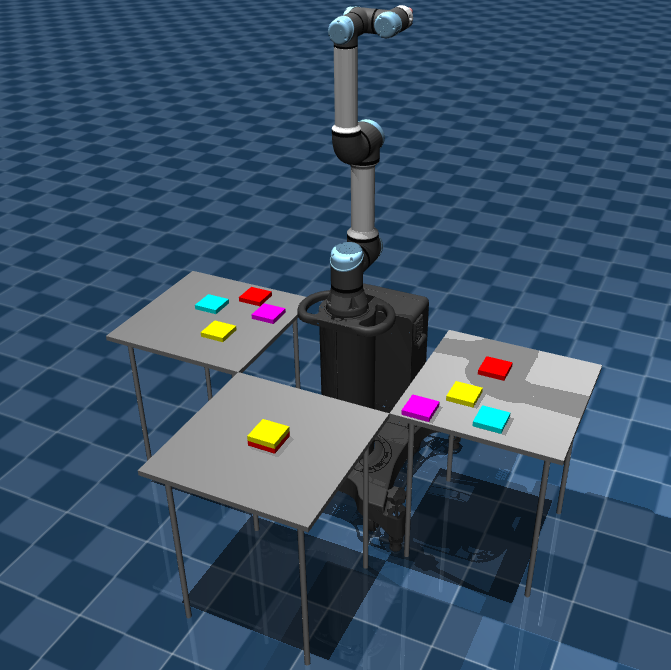


#MuJoCo's key concepts

Overview of MuJoCo's Modeling Approach
MuJoCo’s modeling framework is designed for simulating physics-based environments. It uses XML files to define model components, allowing a structured, hierarchical setup for complex simulations.
Models consist of various elements (e.g., bodies, joints, actuators, sensors) that interact according to the principles of physics, creating highly realistic simulations.



The `xml` string is written in MuJoCo's [MJCF](http://www.mujoco.org/book/modeling.html), which is an [XML](https://en.wikipedia.org/wiki/XML#Key_terminology)-based modeling language.
  - The only required element is `<mujoco>`. The smallest valid MJCF model is `<mujoco/>` which is a completely empty model.
  - All physical elements live inside the `<worldbody>` which is always the top-level body and constitutes the global origin in Cartesian coordinates.
- We define two geoms in the world named `red_box` and `green_sphere`.

In [ ]:
#@title Build a simple Mujoco model

xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""

The `from_xml_string()` method evokes the model compiler, which creates a binary `mjModel` instance.

In [ ]:
#@title Run to show an image
import mujoco
import mediapy as media

model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())


❓ **Question:**
 The `red_box` has no position, the `green_sphere` has no type, why is that?

❗ **Answer:** MJCF attributes have *default values*. The default position is `0 0 0`, the default geom type is `sphere`. The MJCF language is described in the documentation's [XML Reference chapter](https://mujoco.readthedocs.io/en/latest/XMLreference.html).

##MoJoco Model

Model represents the static parameters and configuration of your simulation environment. It includes all the fixed properties that define the system, such as the geometry, mass, inertia, joint types, kinematic tree structure, material properties, and more.
Each model contains the *model description*. The complete description of `mjModel` can be found at the end of the header file [`mjmodel.h`](https://github.com/google-deepmind/mujoco/blob/main/include/mujoco/mjmodel.h).

Contents:

* **Geometric Information:**
Shapes, sizes, and positions of bodies and geoms.
* **Physical Properties:**
Masses, inertias, and densities.
* **Joints and Actuators:**
 * Types of joints (hinge, slide, ball), joint limits, damping, stiffness.
 * Actuator definitions, control parameters.
* **Kinematic Tree Structure:**
Parent-child relationships between bodies.
* **Material and Visual Properties:**
Textures, materials, colors, and other rendering details.
* **Simulation Options:**
Gravity, timestep, solver parameters, friction coefficients.

Here we will examine a few of the quantities that can be found in `mjModel`

`ngeom` - number of geoms in the scene

In [ ]:
model.ngeom

`geom_rgba` - respective colors of geoms in the scene

In [ ]:
model.geom_rgba

`rgba` in MuJoCo (and many other graphic frameworks) is a property used to define the color and transparency of an object.

We can also read the `rgba` for a specific geom

In [ ]:
model.geom('green_sphere').rgba

# MuJoCo Data

Data represents the dynamic state of the simulation at any given time. It includes all the variables that change as the simulation progresses, such as positions, velocities, accelerations, forces, and other time-dependent quantities.

Contents:

* **Kinematic Quantities:**
 * `qpos`: Generalized positions (joint angles, body positions).
 * `qvel`: Generalized velocities (joint velocities, body velocities).
 * `qacc`: Generalized accelerations.
Dynamic Quantities:
 * `xpos`: Cartesian positions of bodies.
 * `xquat`: Orientations of bodies in quaternion form.
 * `xmat`: Orientation matrices of bodies.
 * `act`: Actuator activations.
 * `ctrl`: Control inputs to actuators.
* **Forces and Torques:**
 * `qfrc_applied`: External forces applied to joints.
 * `xfrc_applied`: External forces applied to bodies.
 * `qfrc_constraint`: Constraint forces.
 * `qfrc_inverse`: Inverse dynamics forces.
* **Sensor Data:**
Sensor readings if sensors are defined in the model.
* **Time Variable:**
time: The current simulation time.

`mjData` contains the *state* and quantities that depend on it. In order to make a new `mjData`, we will use `mjModel`

For example, the (x, y, z) positions of our two geoms are in `data.geom_xpos`:

In [ ]:
data = mujoco.MjData(model)

data.geom_xpos

#Basic simulation

To render and display the MuJoCo model in Colab,follow these steps:
1. initialize a `Renderer` object
2. call its `render()` method to capture frames
3. display the frames


In [ ]:
import mujoco
import mediapy as media

model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())

**Oops...**

Someone forgot to turn on the light.

In [ ]:
xml = """
<mujoco>
  <worldbody>
    <!-- Add the light object -->
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())

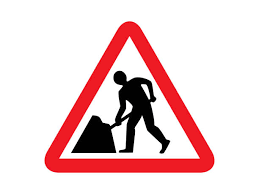

*⚒* **Task 1**: Build a MuJoCo XML model with a cylinder, capsule and a sphere. Add light pointing towards (-1, -1, -1).

In [ ]:
xml = """
<mujoco>
  <worldbody>
    <!-- Enter code here -->
  </worldbody>
</mujoco>
"""

Write the code to visualize the objects

In [ ]:
# Enter code here

# **Solution of ⚒ Task 1**

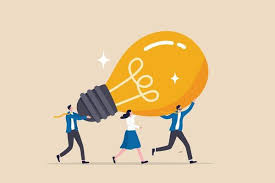

In [ ]:
import mujoco
import mediapy as media

xml = """
<mujoco>
  <worldbody>
    <light name="side_light" pos="1 1 2" dir="-1 -1 -1" diffuse=".8 .8 .8" specular=".2 .2 .2"/>
    <geom name="blue_cylinder" type="cylinder" pos="0.5 0.5 0.3" size="0.4 0.6" rgba="0 0 1 1"/>
    <geom name="yellow_capsule" type="capsule" pos="-0.5 -0.5 0.4" size="0.3 0.4" rgba="1 1 0 1"/>
    <geom name="purple_sphere" type="sphere" pos="0.3 -0.3 0.2" size="0.4" rgba="0.5 0 0.5 1"/>
  </worldbody>
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())


# Understand Degrees of Freedom (DoFs)

In the context of joints in MuJoCo:

* A hinge joint provides 1 DoF (rotation
about a single axis).
* A slide joint provides 1 DoF (translation along a single axis).
* A ball joint provides 3 DoFs (rotation about three axes: pitch, yaw, and roll).
* A free joint provides 6 DoFs (3 for translation and 3 for rotation).

🤖 In the code below we see an example with hinge joint.

In [ ]:
xml = """
<mujoco>
  <asset>
    <texture type="skybox" builtin="gradient" rgb1=".3 .5 .7" rgb2="0 0 0" width="32" height="512"/>
    <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="2 2" texuniform="true" reflectance=".2"/>
  </asset>
  <option timestep="0.01" gravity="0 0 0"/>
  <worldbody>
    <geom size="12 12 12" type="plane" material="grid"/>

    <body name="hook" pos="0 0 1.5">
      <geom name="hook_geom" type="sphere" size="0.05" rgba="0.5 0.5 0.5 1"/>
    </body>

    <body name="hanging_object1" pos="0 0 1.5">
      <joint name="hinge_joint1" type="hinge" axis="1 0 0" pos="0 0 1.5" limited="true" range="-180 180"/>
      <geom name="hanging_geom1" type="capsule" fromto="0 0 1.5 0 0 1.0" size="0.05" rgba="0.1 0.5 0.8 1"/>

      <body name="hanging_object2" pos="0 0 1.0">
        <joint name="hinge_joint2" type="hinge" axis="1 0 0" pos="0 0 1.0" limited="true" range="-180 180"/>
        <geom name="hanging_geom2" type="capsule" fromto="0 0 1.0 0 0 0.5" size="0.05" rgba="0.8 0.1 0.5 1"/>
      </body>
    </body>
  </worldbody>
</mujoco>
"""


## Visualiziton
To visualize the model, we use a MuJoCo-compatible Python library `dm_control`

In [ ]:
#@title Parameter defintions
import mujoco
import numpy as np
import imageio

model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

mujoco.mj_resetData(model, data)

# Set initial angles for the joints to start the motion
data.qpos[0] = 0
data.qpos[1] = 0

# Enable joint visualization
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

# Create a custom camera
camera = mujoco.MjvCamera()

# Set camera parameters
camera.type = mujoco.mjtCamera.mjCAMERA_FREE
camera.fixedcamid = -1
camera.trackbodyid = -1
camera.lookat[:] = [0.0, 0.0, 2.0] # Focus on the center of the pendulum
camera.distance = 4.0              # Adjust to zoom in/out
camera.azimuth = 45                # Rotate around vertical axis
camera.elevation = -30             # Tilt up/down

# Simulation parameters
duration = 10.0  # seconds
framerate = 60   # Hz
frames = []

In [ ]:
#@title Simulation run
# Simulate and collect frames
with mujoco.Renderer(model) as renderer:
    while data.time < duration:
        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, scene_option=scene_option, camera=camera)
            pixels = renderer.render()
            frames.append(pixels)


In [ ]:
#@title Display

display_video(frames, framerate, 'triple_pendulum_simulation.mp4')

## How Gravity Works

Gravity is set in the `option` element as a vector: `gravity="0 0 -9.81"` .

The vector [0, 0, -9.81] represents acceleration in meters per second squared in the Z-axis. We can ajust it if needed.


In [ ]:
import mujoco
import numpy as np
import imageio

xml = """
<mujoco>
  <asset>
    <texture type="skybox" builtin="gradient" rgb1=".3 .5 .7" rgb2="0 0 0" width="32" height="512"/>
    <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="2 2" texuniform="true" reflectance=".2"/>
  </asset>

  <option timestep="0.01" gravity="0 0 -9.81"/>
  <worldbody>
    <geom size="12 12 12" type="plane" material="grid"/>

    <body name="hook" pos="0 0 1.5">
      <geom name="hook_geom" type="sphere" size="0.05" rgba="0.5 0.5 0.5 1"/>
    </body>

    <body name="hanging_object1" pos="0 0 1.5">
      <joint name="hinge_joint1" type="hinge" axis="1 0 0" pos="0 0 1.5" limited="true" range="-180 180"/>
      <geom name="hanging_geom1" type="capsule" fromto="0 0 1.5 0 0 1.0" size="0.05" rgba="0.1 0.5 0.8 1"/>

      <body name="hanging_object2" pos="0 0 1.0">
        <joint name="hinge_joint2" type="hinge" axis="1 0 0" pos="0 0 1.0" limited="true" range="-180 180"/>
        <geom name="hanging_geom2" type="capsule" fromto="0 0 1.0 0 0 0.5" size="0.05" rgba="0.8 0.1 0.5 1"/>
      </body>
    </body>
  </worldbody>
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

mujoco.mj_resetData(model, data)

#model.opt.gravity = (0, 0, 10)

data.qpos[0] = np.pi / 6  # 30 degrees
data.qpos[1] = -np.pi / 6 # -30 degrees

scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

camera = mujoco.MjvCamera()

camera.type = mujoco.mjtCamera.mjCAMERA_FREE
camera.fixedcamid = -1
camera.trackbodyid = -1
camera.lookat[:] = [0.0, 0.0, 2.0] # Focus on the center of the pendulum
camera.distance = 4.0              # Adjust to zoom in/out
camera.azimuth = 45                # Rotate around vertical axis
camera.elevation = -30             # Tilt up/down

duration = 10.0  # seconds
framerate = 60   # Hz
frames = []

with mujoco.Renderer(model) as renderer:
    while data.time < duration:
        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, scene_option=scene_option, camera=camera)
            pixels = renderer.render()
            frames.append(pixels)

display_video(frames, framerate, 'triple_pendulum_simulation.mp4')


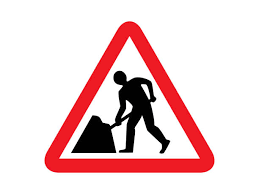

*⚒* **Task 1**: Build a MuJoCo XML pendulum. The pendulum should consist of a single rod connected to a fixed point via a hinge joint, allowing it to swing under the influence of gravity. Set the initial angle of the pendulum to 45 degrees to initiate motion. Run the simulation for 10 seconds, capture the frames, and save the animation as a video file named `simple_pendulum_simulation.mp4`.

In [ ]:
import mujoco
import numpy as np
import imageio

# Define the model in XML
xml = """
<mujoco>
  <worldbody>
    <!-- Enter code here -->
  </worldbody>
</mujoco>
"""

# Load the model and simulation data

# Reset simulation data

# Set initial angle for the pendulum to start the motion

# Enable joint visualization
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

# Set up a custom camera (optional)
camera = mujoco.MjvCamera()
camera.type = mujoco.mjtCamera.mjCAMERA_FREE
camera.lookat[:] = [0.0, 0.0, 1]
camera.distance = 3.0
camera.azimuth = 75
camera.elevation = -20

# Simulation parameters
framerate = 60   # Hz
frames = []

# Simulate and collect frames

display_video(frames, framerate)

# **Solution of ⚒ Task 2**

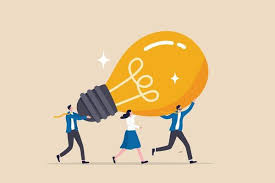

In [ ]:
import mujoco
import numpy as np
import imageio

# Define the model in XML
xml = """
<mujoco>
  <worldbody>
    <body name="pendulum" pos="0 0 1.0">
      <joint name="hinge_joint" type="hinge" axis="0 1 0" pos="0 0 1.0" limited="true" range="-180 180"/>
      <geom name="pendulum_geom" type="capsule" fromto="0 0 1.0 0 0 0.0" size="0.05" rgba="0.1 0.5 0.8 1"/>
    </body>
  </worldbody>
</mujoco>
"""

# Load the model and simulation data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Reset simulation data
mujoco.mj_resetData(model, data)

# Set initial angle for the pendulum to start the motion
data.qpos[0] = np.pi / 4  # 45 degrees

# Enable joint visualization
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

# Set up a custom camera (optional)
camera = mujoco.MjvCamera()
camera.type = mujoco.mjtCamera.mjCAMERA_FREE
camera.lookat[:] = [0.0, 0.0, 1]
camera.distance = 3.0
camera.azimuth = 75
camera.elevation = -20

# Simulation parameters
duration = 10.0  # seconds
framerate = 60   # Hz
frames = []

# Simulate and collect frames
with mujoco.Renderer(model) as renderer:
    while data.time < duration:
        mujoco.mj_step(model, data)  # Step the simulation
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, scene_option=scene_option, camera=camera)
            pixels = renderer.render()
            frames.append(pixels)

display_video(frames, framerate)


# Exaple of a virtual environment
This is a brief introduction to the MuJoCo tool. Below is a video of an environment created using MuJoCo by Yuval Goshen. The environment represent the robots in the lab.

In [ ]:
from IPython.display import Video, display

display(Video("Yuval.env.mp4", embed=True))

Two of MuJoCo's standard humanoid models with the same geometry.

In [ ]:
# Get MuJoCo's standard humanoid model.
print('Getting MuJoCo humanoid XML description from GitHub:')
!git clone https://github.com/google-deepmind/mujoco
with open('mujoco/model/humanoid/humanoid.xml', 'r') as f:
  xml = f.read()

# Load the model, make two MjData's.
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
data2 = mujoco.MjData(model)

# Episode parameters.
duration = 3       # (seconds)
framerate = 60     # (Hz)
data.qpos[0:2] = [-.5, -.5]  # Initial x-y position (m)
data.qvel[2] = 4   # Initial vertical velocity (m/s)
ctrl_phase = 2 * np.pi * np.random.rand(model.nu)  # Control phase
ctrl_freq = 1     # Control frequency

# Visual options for the "ghost" model.
vopt2 = mujoco.MjvOption()
vopt2.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False  # Transparent.
pert = mujoco.MjvPerturb()  # Empty MjvPerturb object
# We only want dynamic objects (the humanoid). Static objects (the floor)
# should not be re-drawn. The mjtCatBit flag lets us do that, though we could
# equivalently use mjtVisFlag.mjVIS_STATIC
catmask = mujoco.mjtCatBit.mjCAT_DYNAMIC

# Simulate and render.
frames = []
with mujoco.Renderer(model, 480, 640) as renderer:
  while data.time < duration:
    # Sinusoidal control signal.
    data.ctrl = np.sin(ctrl_phase + 2 * np.pi * data.time * ctrl_freq)
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      # This draws the regular humanoid from `data`.
      renderer.update_scene(data)

      # Copy qpos to data2, move the humanoid sideways, call mj_forward.
      data2.qpos = data.qpos
      data2.qpos[0] += 1.5
      data2.qpos[1] += 1
      mujoco.mj_forward(model, data2)

      # Call mjv_addGeoms to add the ghost humanoid to the scene.
      mujoco.mjv_addGeoms(model, data2, vopt2, pert, catmask, renderer.scene)

      # Render and add the frame.
      pixels = renderer.render()
      frames.append(pixels)

# Render video at half real-time.
media.show_video(frames, fps=framerate/2)